<a href="https://colab.research.google.com/github/andreamurari/chess_project_off/blob/main/chess_project_off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as skl
import scipy as scp
import statsmodels.api as sm

##**A) Data-set presentation**

This data-set groups data from more than 20,000 games collected from a selection of users on the site Lichess.org. This set contains:
*  Game ID;
*  Rated (Boolean value);
*  Start Time;
*  End Time;
*  Number of Turns;
*  Game Status;
*  Winner;
*  Time Increment;
*  White Player ID;
*  White Player Rating;
*  Black Player ID;
*  Black Player Rating;
*  All Moves in Standard Chess Notation;
*  Opening Eco (Standardised Code for any given opening, list here);
*  Opening Name;
*  Opening Ply (Number of moves in the opening phase);

In [ ]:
chess_df = pd.read_csv('/content/chess.csv')

In [ ]:
chess_df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


In [ ]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [ ]:
chess_df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


***DATA HANDLING***

First it's generated a backup of the original data set:


In [ ]:
chess_df_backup = chess_df.copy()

Then all the columns that will not be used are dropped and two new columns are added:
* "white_win" : equals 1 if winner it's white player, 0 otherwise;
* "black_win" : equals 1 if winner it's black player, 0 otherwise.

In [ ]:
chess_df.drop(['moves', 'white_id', 'black_id', 'id', 'created_at', 'last_move_at', 'rated'], axis=1, inplace = True )

In [ ]:
chess_df['white_win'] = ( chess_df['winner'] == 'white' ) * 1

In [ ]:
chess_df['black_win'] = ( chess_df['winner'] == 'black' ) * 1

In [ ]:
chess_df.head(3)

,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,white_win,black_win
0,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,1,0
1,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,0,1
2,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,1,0


***GENERAL CORRELATION***

Now it' ll be plotted a correlation graphs of the numerical variables in the data set.

In [ ]:
chess_corr = chess_df.corr()

<ipython-input-11-d72e7566516b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  chess_corr = chess_df.corr()


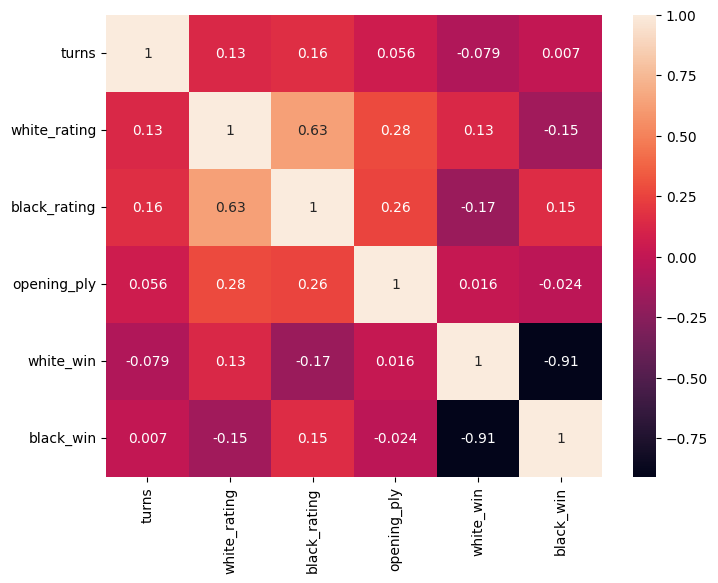

In [ ]:
plt.figure(figsize=(8, 6))
sb.heatmap(chess_corr, annot = True, )

plt.show()

As a first impression, the only parameters that seems to have a little correlation are:

* **white_rating and black_rating:** positive correlation, this is because matchmaking software matches opponents with similar ratings.
* **white_win and black_win:** negative correlation, obviously because if one player win, then the other loose. The correlation is not -1 because there can be some draws.